# Sales Analytics Dashboard - ETL Pipeline

## Overview
This notebook implements an ETL pipeline to import the **UK Retailer E-Commerce Dataset** from Kaggle into our SQL Server database.

**Dataset Source:** [E-Commerce Data - Kaggle](https://www.kaggle.com/datasets/carrie1/ecommerce-data)

**Dataset Size:** ~541,000 transactions from a UK-based online retailer (2010-2011)

---

## Pipeline Steps:
1. **Data Preparation** - Load CSV data from Kaggle
2. **Visualize Data** - Explore data distribution, identify patterns and outliers
3. **Transform** - Clean and validate data
4. **Export Cleaned Data** - generate new cleaned csv file
5. **Final Summery** - Explore cleaned data

---

## Exploring the content of variables
This dataframe contains 8 variables that correspond to:

- **InvoiceNo:** Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
- **StockCode:** Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- **Description:** Product (item) name. Nominal.
- **Quantity:** The quantities of each product (item) per transaction. Numeric.
- **InvoiceDate:** Invice Date and time. Numeric, the day and time when each transaction was generated.
- **UnitPrice:** Unit price. Numeric, Product price per unit in sterling.
- **CustomerID:** Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- **Country:** Country name. Nominal, the name of the country where each customer resides.

---

## 1. Import Dependencies
As a first step, I load all the modules that will be used in this notebook


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

# 1. Data Preparation 
## 1.1 Load CSV Data

In [ ]:
# read the datafile
df = pd.read_csv('raw-data/data.csv', encoding='latin-1')
print('Dataframe dimensions:', df.shape)

print(f"Loaded {len(df):,} rows")
print(f"Columns: {list(df.columns)}")

Dataframe dimensions: (541909, 8)
Loaded 541,909 rows
Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


## 1.2 Initial Data Inspection

In [10]:
# Display first rows
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [11]:
# Data types and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [12]:
# Statistical summary
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## 1.3 Missing Values Analysis

In [13]:
# Check for missing values
print("🔍 Missing Values Analysis:\n")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing Count': missing.values,
    'Percentage': missing_pct.values
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
else:
    print("✅ No missing values found!")

🔍 Missing Values Analysis:

     Column  Missing Count  Percentage
 CustomerID         135080       24.93
Description           1454        0.27


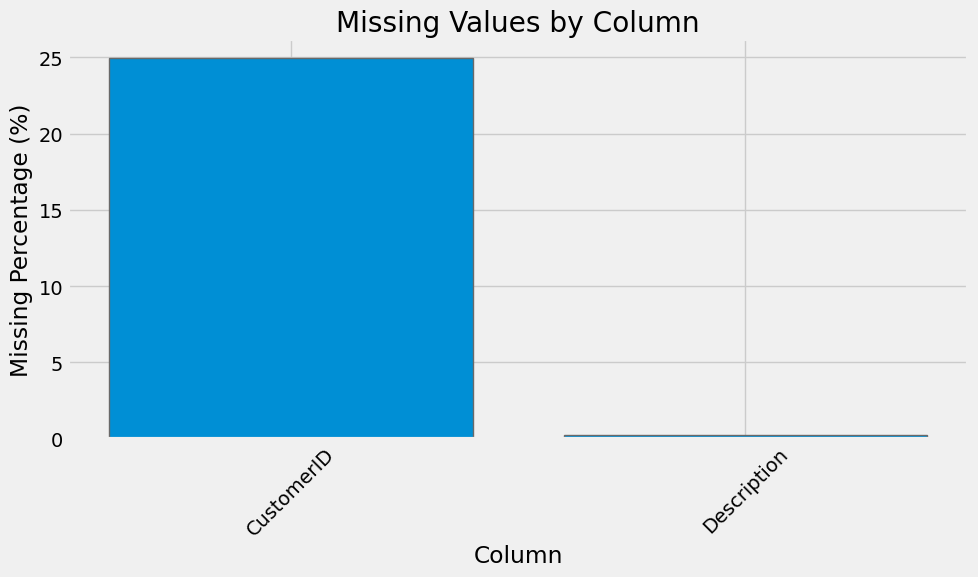

In [14]:
# Visualize missing values
if len(missing_df) > 0:
    plt.figure(figsize=(10, 6))
    plt.bar(missing_df['Column'], missing_df['Percentage'])
    plt.xlabel('Column')
    plt.ylabel('Missing Percentage (%)')
    plt.title('Missing Values by Column')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 1.4 Unique Values Analysis

In [15]:
print("Unique Values Analysis:\n")
print(f"  Unique Invoices: {df['InvoiceNo'].nunique():,}")
print(f"  Unique Products (StockCode): {df['StockCode'].nunique():,}")
print(f"  Unique Descriptions: {df['Description'].nunique():,}")
print(f"  Unique Customers: {df['CustomerID'].nunique():,}")
print(f"  Unique Countries: {df['Country'].nunique():,}")
print(f"\n  Duplicate Rows: {df.duplicated().sum():,}")

Unique Values Analysis:

  Unique Invoices: 25,900
  Unique Products (StockCode): 4,070
  Unique Descriptions: 4,223
  Unique Customers: 4,372
  Unique Countries: 38

  Duplicate Rows: 5,268


# 2. Visualize Data
## 2.1 Geographic Distribution

🌍 Top 10 Countries by Transaction Count:

Country
United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Netherlands         2371
Belgium             2069
Switzerland         2002
Portugal            1519
Australia           1259
Name: count, dtype: int64


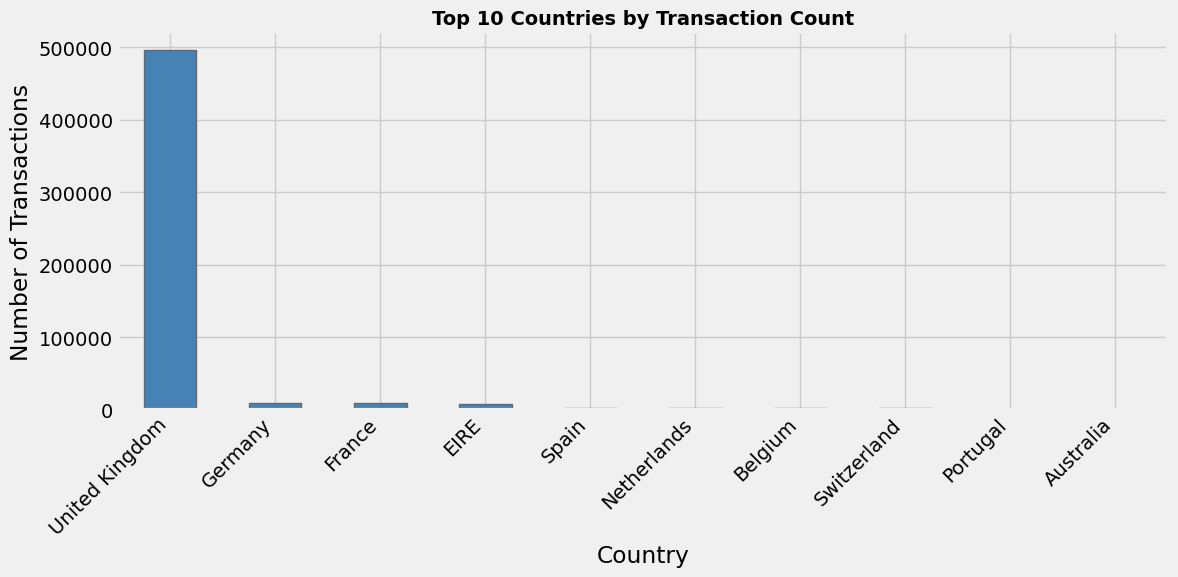

In [ ]:
# Top 10 countries by transaction count
print("🌍 Top 10 Countries by Transaction Count:\n")
country_counts = df['Country'].value_counts().head(10)
print(country_counts)

# Visualize
plt.figure(figsize=(12, 6))
country_counts.plot(kind='bar', color='steelblue')
plt.title('Top 10 Countries by Transaction Count', fontsize=14, fontweight='bold')
plt.xlabel('Country')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Choropleth Map: Number of orders per country
temp = df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()

data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

## 2.2 Price Distribution Analysis

In [19]:
# Unit Price distribution
print(" Unit Price Statistics:\n")
print(f"  Min: £{df['UnitPrice'].min():.2f}")
print(f"  Max: £{df['UnitPrice'].max():.2f}")
print(f"  Mean: £{df['UnitPrice'].mean():.2f}")
print(f"  Median: £{df['UnitPrice'].median():.2f}")
print(f"  Std Dev: £{df['UnitPrice'].std():.2f}")

 Unit Price Statistics:

  Min: £-11062.06
  Max: £38970.00
  Mean: £4.61
  Median: £2.08
  Std Dev: £96.76


### Interpretation of Negative Prices:

The dataset contains **negative unit prices** (min: £-11,062.06), since there is no explanation from the author I would interpret that it represents:

- **Refunds/Returns:** When customers return products, the transaction is recorded with a negative price
- **Credit Notes:** Adjustments or compensations issued to customers


These negative values will be filtered out during the data cleaning phase (Step 3), as our analytics dashboard focuses on actual sales revenue rather than returns.


## 2.3 Temporal Analysis

 Temporal Statistics:

  Date Range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00
  Time Span: 373 days


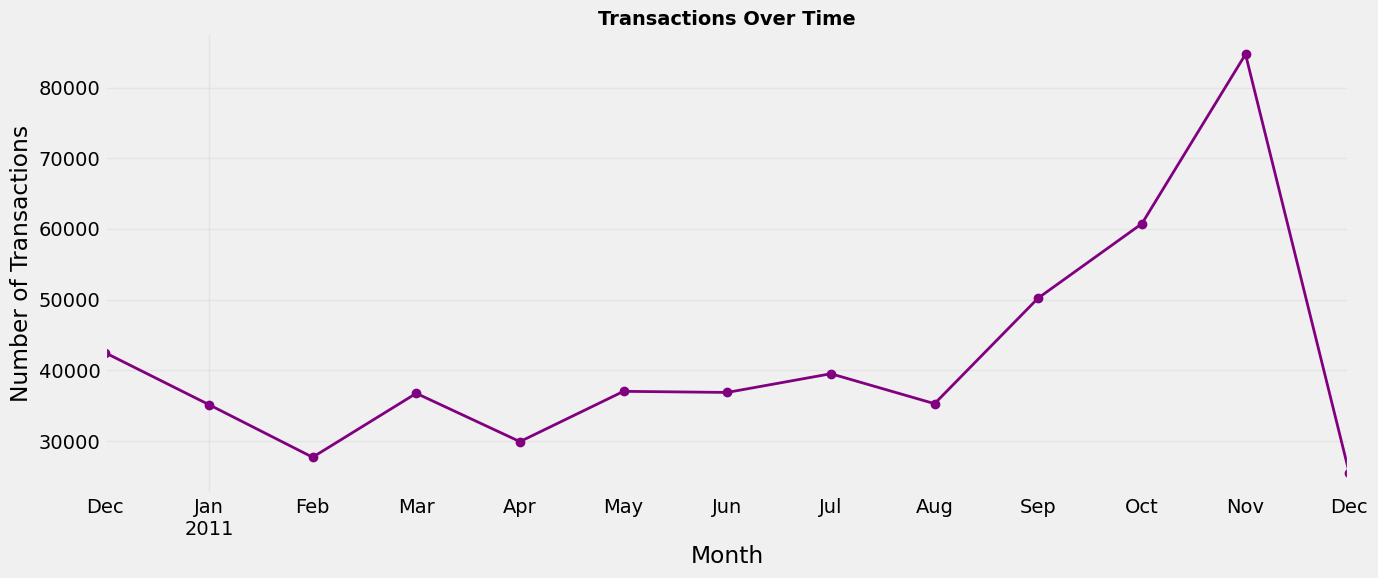

In [23]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(" Temporal Statistics:\n")
print(f"  Date Range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")
print(f"  Time Span: {(df['InvoiceDate'].max() - df['InvoiceDate'].min()).days} days")

# Transactions over time
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')
transactions_over_time = df.groupby('YearMonth').size()

plt.figure(figsize=(14, 6))
transactions_over_time.plot(kind='line', marker='o', color='purple', linewidth=2)
plt.title('Transactions Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2.4 Top Products Analysis

 Top 10 Products by Transaction Count:

  1. WHITE HANGING HEART T-LIGHT HOLDER: 2,369 transactions
  2. REGENCY CAKESTAND 3 TIER: 2,200 transactions
  3. JUMBO BAG RED RETROSPOT: 2,159 transactions
  4. PARTY BUNTING: 1,727 transactions
  5. LUNCH BAG RED RETROSPOT: 1,638 transactions
  6. ASSORTED COLOUR BIRD ORNAMENT: 1,501 transactions
  7. SET OF 3 CAKE TINS PANTRY DESIGN : 1,473 transactions
  8. PACK OF 72 RETROSPOT CAKE CASES: 1,385 transactions
  9. LUNCH BAG  BLACK SKULL.: 1,350 transactions
  10. NATURAL SLATE HEART CHALKBOARD : 1,280 transactions


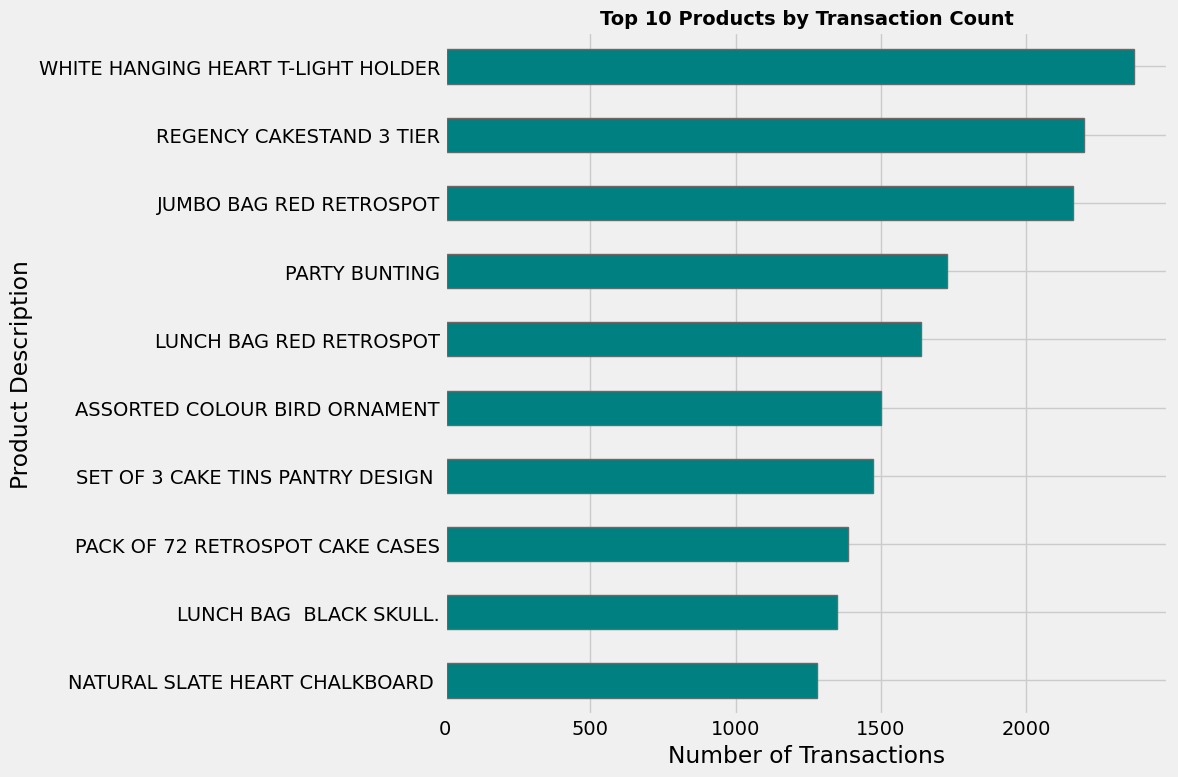

In [25]:
# Top 10 products by transaction count
print(" Top 10 Products by Transaction Count:\n")
top_products = df['Description'].value_counts().head(10)
for idx, (product, count) in enumerate(top_products.items(), 1):
    print(f"  {idx}. {product}: {count:,} transactions")

# Visualize
plt.figure(figsize=(12, 8))
top_products.plot(kind='barh', color='teal')
plt.title('Top 10 Products by Transaction Count', fontsize=14, fontweight='bold')
plt.xlabel('Number of Transactions')
plt.ylabel('Product Description')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 3. TRANSFORM
## 3.1 Remove invalid data

In [28]:
# Store original count
original_count = len(df)
print(f" Original rows: {original_count:,}\n")

# 1. Remove rows with missing CustomerID
rows_before = len(df)
df = df.dropna(subset=['CustomerID'])
print(f" Removed missing CustomerID: {rows_before - len(df):,} rows")

# 2. Remove rows with missing Description
rows_before = len(df)
df = df.dropna(subset=['Description'])
print(f" Removed missing Description: {rows_before - len(df):,} rows")

# 3. Remove negative quantities (returns)
rows_before = len(df)
df = df[df['Quantity'] > 0]
print(f" Removed negative quantities: {rows_before - len(df):,} rows")

# 4. Remove zero or negative prices
rows_before = len(df)
df = df[df['UnitPrice'] > 0]
print(f" Removed invalid prices: {rows_before - len(df):,} rows\n")


print(f" Total rows removed: {original_count - len(df):,} ({((original_count - len(df)) / original_count * 100):.1f}%)")
print(f" Remaining rows: {len(df):,}")

 Original rows: 397,884

 Removed missing CustomerID: 0 rows
 Removed missing Description: 0 rows
 Removed negative quantities: 0 rows
 Removed invalid prices: 0 rows

 Total rows removed: 0 (0.0%)
 Remaining rows: 397,884


## 3.2 Feature Engineering

In [29]:
# Calculate TotalAmount
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

# Clean CustomerID (convert to integer then string)
df['CustomerID'] = df['CustomerID'].astype(int).astype(str)

# Clean StockCode and Description
df['StockCode'] = df['StockCode'].astype(str).str.strip()
df['Description'] = df['Description'].astype(str).str.strip()

# Remove temporary column
df = df.drop(['IsCancelled', 'YearMonth'], axis=1, errors='ignore')

## 3.3 Final Cleaned Data Preview

In [30]:
print(" Cleaned Data Sample:")
df.head(5)

 Cleaned Data Sample:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [31]:
# Final summary statistics
print(" Final Data Summary:\n")
print(f"Date Range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")
print(f"\nTotal Revenue: £{df['TotalAmount'].sum():,.2f}")
print(f"Average Transaction Value: £{df['TotalAmount'].mean():.2f}")
print(f"Median Transaction Value: £{df['TotalAmount'].median():.2f}")
print(f"\nUnique Customers: {df['CustomerID'].nunique():,}")
print(f"Unique Products: {df['StockCode'].nunique():,}")
print(f"Unique Countries: {df['Country'].nunique():,}")

 Final Data Summary:

Date Range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00

Total Revenue: £8,911,407.90
Average Transaction Value: £22.40
Median Transaction Value: £11.80

Unique Customers: 4,338
Unique Products: 3,665
Unique Countries: 37


# 4. Export Cleaned Data
## 4.1 Export Cleaned Data to CSV

In [32]:
# Export cleaned data
output_file = 'cleaned-data/cleaned_data.csv'
df.to_csv(output_file, index=False, encoding='utf-8')

print(f" Cleaned data exported successfully!")
print(f" Location: {output_file}")
print(f" Rows: {len(df):,}")

 Cleaned data exported successfully!
 Location: cleaned-data/cleaned_data.csv
 Rows: 397,884


# 5. Final Summery

In [33]:
print("\n Summary:")
print(f"  • Original CSV rows: {original_count:,}")
print(f"  • Rows removed: {original_count - len(df):,} ({((original_count - len(df)) / original_count * 100):.1f}%)")
print(f"  • Cleaned rows: {len(df):,}")
print(f"\n Output:")
print(f"  • File: {output_file}")
print(f"\n Key Metrics:")
print(f"  • Date Range: {df['InvoiceDate'].min().date()} to {df['InvoiceDate'].max().date()}")
print(f"  • Total Revenue: £{df['TotalAmount'].sum():,.2f}")
print(f"  • Unique Customers: {df['CustomerID'].nunique():,}")
print(f"  • Unique Products: {df['StockCode'].nunique():,}")
print(f"  • Unique Countries: {df['Country'].nunique():,}")


 Summary:
  • Original CSV rows: 397,884
  • Rows removed: 0 (0.0%)
  • Cleaned rows: 397,884

 Output:
  • File: cleaned-data/cleaned_data.csv

 Key Metrics:
  • Date Range: 2010-12-01 to 2011-12-09
  • Total Revenue: £8,911,407.90
  • Unique Customers: 4,338
  • Unique Products: 3,665
  • Unique Countries: 37
